In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)

In [2]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


In [3]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

# CNN

### Prepare the data

In [4]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

batch_size = 128 # How big of a set of data to use for every training epoch

In [5]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, #for replicability. Anyways they are already shuffled?
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Building training set.
Found 18900 validated image filenames belonging to 10 classes.

Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

Building test set
Found 2700 validated image filenames belonging to 10 classes.


In [6]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)

### Define the model

In [7]:
# Todo: remove layers and test
# (Todo: regularize)

model = Sequential()
# start of VGG16
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# end of VGG16
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [9]:
model_path = "/kaggle/working/eurosat_rgb_ablated_vgg16_model.h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [10]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [11]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=50,
    verbose=1,
)

Epoch 1/50
148/148 [==============================] - 120s 720ms/step - loss: 1.9299 - accuracy: 0.2091 - val_loss: 1.5894 - val_accuracy: 0.2922
Epoch 2/50
148/148 [==============================] - 27s 183ms/step - loss: 1.3663 - accuracy: 0.4305 - val_loss: 1.0401 - val_accuracy: 0.6037
Epoch 3/50
148/148 [==============================] - 28s 189ms/step - loss: 0.9885 - accuracy: 0.6336 - val_loss: 0.7191 - val_accuracy: 0.7365
Epoch 4/50
148/148 [==============================] - 28s 186ms/step - loss: 0.7290 - accuracy: 0.7377 - val_loss: 0.6837 - val_accuracy: 0.7507
Epoch 5/50
148/148 [==============================] - 27s 184ms/step - loss: 0.6521 - accuracy: 0.7689 - val_loss: 0.5931 - val_accuracy: 0.7861
Epoch 6/50
148/148 [==============================] - 27s 182ms/step - loss: 0.5782 - accuracy: 0.7964 - val_loss: 0.6200 - val_accuracy: 0.7789
Epoch 7/50
148/148 [==============================] - 27s 185ms/step - loss: 0.5237 - accuracy: 0.8147 - val_loss: 0.4703 - val_a

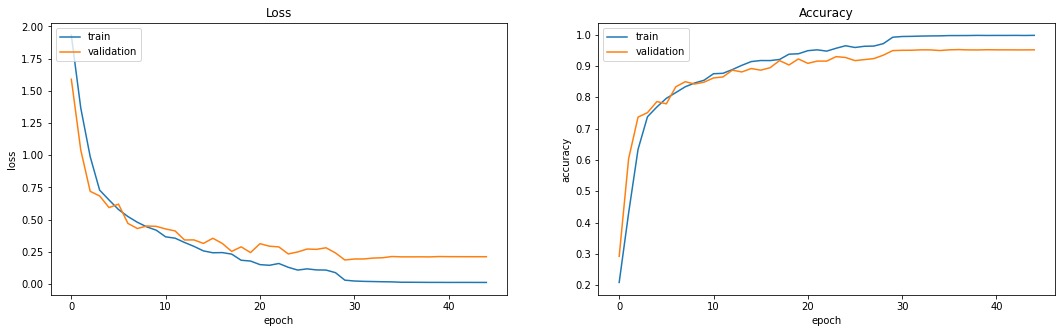

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig("/kaggle/working/exp1_loss_accuracy.png")

## Predict and Evaluate Model

In [13]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 9s 398ms/step - loss: 0.1935 - accuracy: 0.9533


In [14]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 3s 906us/step


In [15]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9633    0.9538       300
           1     0.9835    0.9933    0.9884       300
           2     0.9220    0.9067    0.9143       300
           3     0.9417    0.9040    0.9224       250
           4     0.9636    0.9520    0.9577       250
           5     0.9548    0.9500    0.9524       200
           6     0.8689    0.9280    0.8975       250
           7     0.9933    0.9833    0.9883       300
           8     0.9518    0.9480    0.9499       250
           9     1.0000    0.9900    0.9950       300

    accuracy                         0.9533      2700
   macro avg     0.9524    0.9519    0.9520      2700
weighted avg     0.9539    0.9533    0.9534      2700



In [16]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)

[[289   0   1   2   0   3   2   0   3   0]
 [  0 298   0   0   0   0   0   0   2   0]
 [  3   3 272   1   1   1  18   1   0   0]
 [  3   0   1 226   4   2   8   1   5   0]
 [  0   0   4   5 238   0   3   0   0   0]
 [  2   0   3   0   0 190   4   0   1   0]
 [  3   0  11   0   2   2 232   0   0   0]
 [  0   0   1   2   2   0   0 295   0   0]
 [  5   1   2   4   0   1   0   0 237   0]
 [  1   1   0   0   0   0   0   0   1 297]]


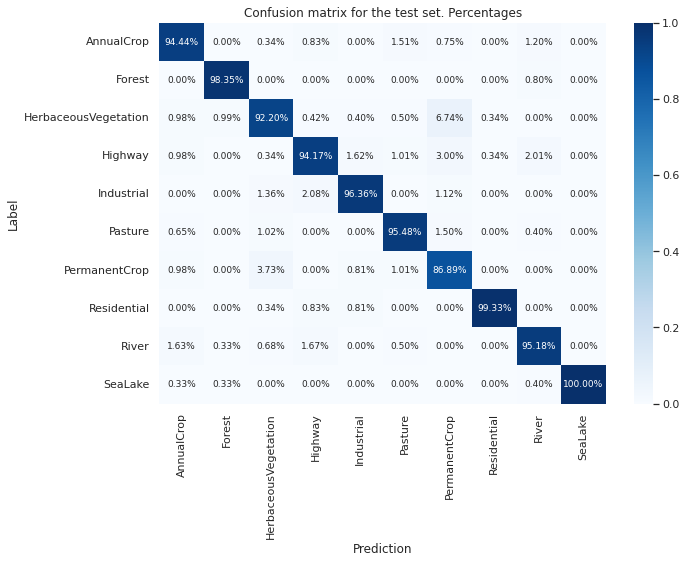

<Figure size 432x288 with 0 Axes>

In [17]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/kaggle/working/exp1_confusion_percentages.png")

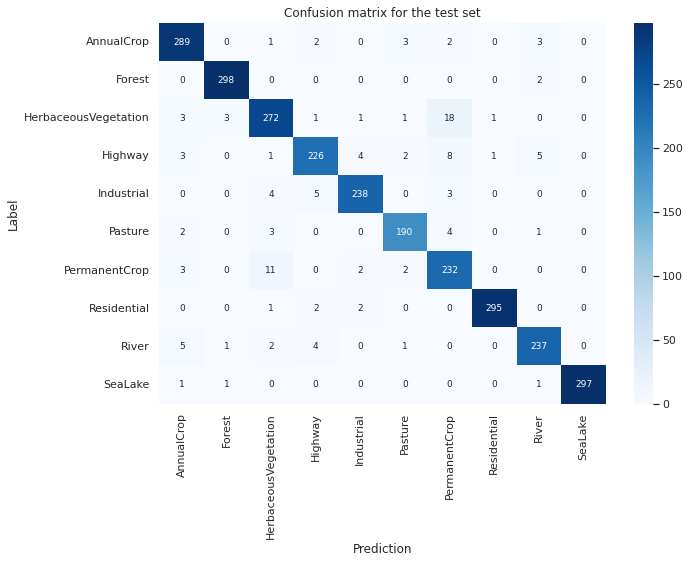

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig("/kaggle/working/exp1_confusion.png")

In [19]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

In [20]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

126 wrong predictions out of 2700


### Plot wrong predicitons

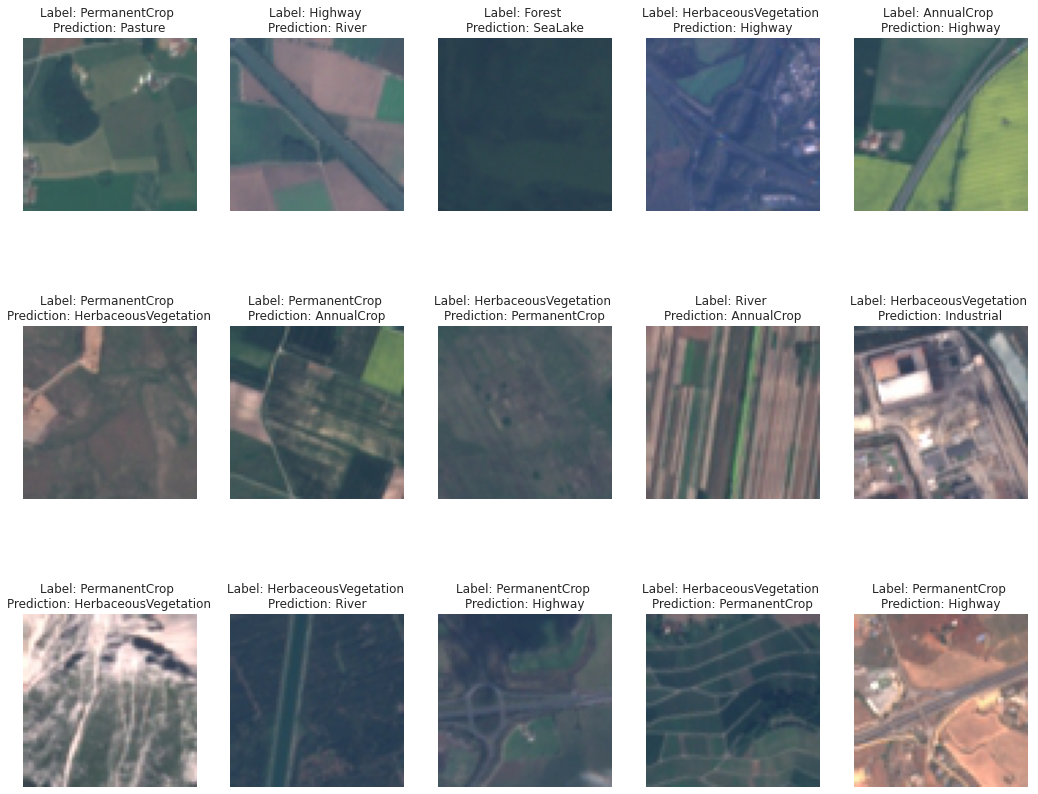

In [21]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("/kaggle/working/exp1_mislabeled_results.png")